# INF-2600-1 24V Artificial Intelligence: Assignment 3 Pre-code
This code implements a Bayesian Network model for Analyzing Sensor Data for Weather Prediction using the pgmpy library in Python.


### BUILDING THE STRUCTURE OF BAYESIAN NETWORK: Using PgmPy
#### Install Package: `!pip install pgmpy`

In [1]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.


c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\python.exe: No module named pip


In [2]:
import os
os.getcwd()


'c:\\Users\\Antonio Luque\\Desktop\\Carpetas\\UIT\\INF-2600 AI\\Assignment 3'

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\python.exe: No module named pip


In [4]:
# Including the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Factoring the dataset

In [42]:
# Import data, make a copy of the original

df0 = pd.read_csv('./seattle-weather.csv')
dfc1 = df0.copy()
dfc1.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [43]:
# Get characteristics of dataset including columns with missing data as well:
dfc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [44]:
# Checking the unique values in the 'weather' column
unique_fields = dfc1['weather'].unique()
print(unique_fields)

['drizzle' 'rain' 'sun' 'snow' 'fog']


In [45]:
dfc1.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [46]:
# Put categorical varaibles in a list
categorical_lst = ['date','weather']
# Create a seperate & smaller dataframe for categorical variables
dfc2a = pd.DataFrame(dfc1, columns=categorical_lst, copy=True)
dfc2a.head()

,date,weather
0,2012-01-01,drizzle
1,2012-01-02,rain
2,2012-01-03,rain
3,2012-01-04,rain
4,2012-01-05,rain


In [47]:
# Put all continuous variables into a list
continuous_lst = ['precipitation', 'temp_max', 'temp_min', 'wind']
# Create a seperate & smaller dataframe for our chosen variables. Use 'copy=True' so changes wont affect original
dfc2b = pd.DataFrame(dfc1, columns=continuous_lst, copy=True)
dfc2b.head()

,precipitation,temp_max,temp_min,wind
0,0.0,12.8,5.0,4.7
1,10.9,10.6,2.8,4.5
2,0.8,11.7,7.2,2.3
3,20.3,12.2,5.6,4.7
4,1.3,8.9,2.8,6.1


### Create new dataframe

In [48]:
# Create new df with variables we want to work with:
new_cols = ['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather']

df = df0[new_cols]
# df.head()

In [49]:
# Let's show all columns with missing data as well:
df[df.isnull().any(axis=1)] # any missing data in columns
df.isnull().any()

date             False
precipitation    False
temp_max         False
temp_min         False
wind             False
weather          False
dtype: bool

In [50]:
num_stdv = 1

# Define the labels dictionary
labels = {
    'precipitation': ['low', 'mid', 'high'],
    'temp_max': ['low', 'mid', 'high'],
    'temp_min': ['low', 'mid', 'high'],
    'wind': ['low', 'mid', 'high']
}

# Create bounds for continuous labels
for col in df.columns:
    if col in labels:
        col_mean = df[col].mean()
        col_stdv = df[col].std()
        lower_bound = col_mean - col_stdv * num_stdv
        upper_bound = col_mean + col_stdv * num_stdv
        bins = [-float('inf'), lower_bound, upper_bound, float('inf')]
        df[col] = pd.cut(df[col], bins=bins, labels=labels[col])

df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,mid,mid,mid,high,drizzle
1,2012-01-02,high,mid,low,mid,rain
2,2012-01-03,mid,mid,mid,mid,rain
3,2012-01-04,high,mid,mid,high,rain
4,2012-01-05,mid,low,low,high,rain


# Creating Bayes Nets

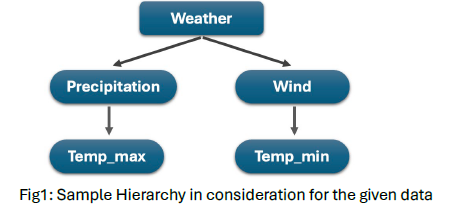

In [14]:
# Define the hierarchy
modelfig1 = BayesianNetwork([
    ('weather', 'precipitation'), ('weather', 'wind'),
    ('precipitation', 'temp_max'),
    ('wind', 'temp_min')
])

# And, the states for each variables
weather_states = ['drizzle', 'rain', 'sun', 'snow', 'fog']
precipitation_states = ['low', 'mid', 'high']
wind_states = ['low', 'mid', 'high']
temp_max_states = ['low', 'mid', 'high']
temp_min_states = ['low', 'mid', 'high']

In [15]:
# Calculate Probabilities

# Weather does not have any parents so all we need are the marginal probabilities of observing each weather type
weather_marginal = (df['weather'].value_counts()/len(df['weather'])).round(3)
weather_marginal = np.array([[value] for value in weather_marginal])

# Joint Propabilities
# Create dict where key=parent, value=child
var_dict = {'weather': ['precipitation', 'wind'],
            'precipitation': ['temp_max'],
            'wind': ['temp_min']
            }

# Create conditional distributions and store results in a list
cpd_lst = []
for key, value in var_dict.items():
    length = len(value)
    for i in range(length):
        value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
        cpd = value_given_key.unstack(fill_value=0).to_numpy().T
        cpd_lst.append(cpd)
# Note that we get 3 Nan values in the above conditional distributions. This is because one of the type of precipitation (low) did not contain any relation with temp_max.
# Therefore, normalization, does not produce the intended result.
# To mitigate this, we replace Nan with the equal probability within the three values, i.e., 0.33
cpd_lst[2][:,0] = .33
cpd_lst

C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_5416\1747450688.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_5416\1747450688.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()


[array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 1.        , 0.7800312 , 0.69230769, 1.        ],
        [0.        , 0.        , 0.2199688 , 0.30769231, 0.        ]]),
 array([[0.30188679, 0.35643564, 0.10452418, 0.07692308, 0.140625  ],
        [0.67924528, 0.58415842, 0.64118565, 0.38461538, 0.775     ],
        [0.01886792, 0.05940594, 0.25429017, 0.53846154, 0.084375  ]]),
 array([[0.33      , 0.16996951, 0.18120805],
        [0.33      , 0.61128049, 0.80536913],
        [0.33      , 0.21875   , 0.01342282]]),
 array([[0.26066351, 0.14229249, 0.18067227],
        [0.61137441, 0.5958498 , 0.77310924],
        [0.12796209, 0.26185771, 0.04621849]])]

In [16]:
# Creating tabular conditional probability distribution
weather_cpd = TabularCPD(variable='weather', variable_card=5, values=weather_marginal, state_names={'weather': weather_states})

precipitation_cpd = TabularCPD(variable='precipitation', variable_card=3, evidence=['weather'], evidence_card=[5],
                               values=cpd_lst[0], state_names={'precipitation': precipitation_states, 'weather': weather_states})

wind_cpd = TabularCPD(variable='wind', variable_card=3, evidence=['weather'], evidence_card=[5],
                               values=cpd_lst[1], state_names={'wind': wind_states, 'weather': weather_states})

temp_max_cpd = TabularCPD(variable='temp_max', variable_card=3, evidence=['precipitation'], evidence_card=[3],
                               values=cpd_lst[2], state_names={'temp_max': temp_max_states, 'precipitation': precipitation_states})

temp_min_cpd = TabularCPD(variable='temp_min', variable_card=3, evidence=['wind'], evidence_card=[3],
                               values=cpd_lst[3], state_names={'temp_min': temp_min_states, 'wind': wind_states})


In [17]:
# Add CPDs and factors to the model
modelfig1.add_cpds(weather_cpd, precipitation_cpd, wind_cpd, temp_max_cpd, temp_min_cpd)

# Check if model is consistent
modelfig1.check_model()

True

In [18]:
# Viewing nodes of the model
modelfig1.nodes()

NodeView(('weather', 'precipitation', 'wind', 'temp_max', 'temp_min'))

In [19]:
# Viewing edges of the model
modelfig1.edges()

OutEdgeView([('weather', 'precipitation'), ('weather', 'wind'), ('precipitation', 'temp_max'), ('wind', 'temp_min')])

In [20]:
# Print the probability table of the weather node
print(weather_cpd)

# Print the probability table of the wind node
print(wind_cpd)

+------------------+-------+
| weather(drizzle) | 0.439 |
+------------------+-------+
| weather(rain)    | 0.438 |
+------------------+-------+
| weather(sun)     | 0.069 |
+------------------+-------+
| weather(snow)    | 0.036 |
+------------------+-------+
| weather(fog)     | 0.018 |
+------------------+-------+
+------------+----------------------+-----+--------------+
| weather    | weather(drizzle)     | ... | weather(fog) |
+------------+----------------------+-----+--------------+
| wind(low)  | 0.3018867924528302   | ... | 0.140625     |
+------------+----------------------+-----+--------------+
| wind(mid)  | 0.6792452830188679   | ... | 0.775        |
+------------+----------------------+-----+--------------+
| wind(high) | 0.018867924528301886 | ... | 0.084375     |
+------------+----------------------+-----+--------------+


In [21]:
# Independcies in the model
modelfig1.get_independencies()
# Checking independcies of a particular node
modelfig1.local_independencies('temp_max')

(temp_max ⟂ wind, weather, temp_min | precipitation)

# Task 1.2

In [22]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(modelfig1)

In [23]:

# Question 1: (a) What is the probability of high wind when the weather is sunny? 
probs_wind_by_sun = inference.query(variables=['wind'], evidence={'weather': 'sun'})
print(probs_wind_by_sun)

prob_high_wind_when_sunny = probs_wind_by_sun.values[2] * 100
print(f"Probability of high wind when the weather is sunny:{prob_high_wind_when_sunny:.4f}%")


# (b) What is the probability of sunny weather when the wind is high?
prob_weather_by_high_wind = inference.query(variables=['weather'], evidence={'wind': 'high'})
print(prob_weather_by_high_wind)

prob_sunny_when_high_wind = prob_weather_by_high_wind.values[2] * 100  # Convert fraction to percentage
print(f"Probability of sunny weather when the wind is high: {prob_sunny_when_high_wind:.4f}%")

+------------+-------------+
| wind       |   phi(wind) |
+============+=============+
| wind(low)  |      0.1045 |
+------------+-------------+
| wind(mid)  |      0.6412 |
+------------+-------------+
| wind(high) |      0.2543 |
+------------+-------------+
Probability of high wind when the weather is sunny:25.4290%
+------------------+----------------+
| weather          |   phi(weather) |
+==================+================+
| weather(drizzle) |         0.1139 |
+------------------+----------------+
| weather(rain)    |         0.3576 |
+------------------+----------------+
| weather(sun)     |         0.2412 |
+------------------+----------------+
| weather(snow)    |         0.2664 |
+------------------+----------------+
| weather(fog)     |         0.0209 |
+------------------+----------------+
Probability of sunny weather when the wind is high: 24.1175%


In [24]:
# Question 2:
# (a) Calculate all the possible joint probability and determine the best probable condition. Explain your results?
joint_probability = inference.query(variables=['weather', 'wind', 'precipitation', 'temp_max', 'temp_min'])
print(joint_probability)

def factor_to_df(factor):
    """Converts a DiscreteFactor object to a pandas DataFrame."""
    # Flatten the values
    flat_values = factor.values.flatten()
    # Create a multi-index from the state names
    index = pd.MultiIndex.from_product(factor.state_names.values(), names=factor.variables)
    # Create the DataFrame
    df = pd.DataFrame(flat_values, index=index, columns=['Probability'])
    return df.reset_index()

# Assuming 'joint_probability' is your DiscreteFactor object from pgmpy
df = factor_to_df(joint_probability)

# Find the row with the maximum probability
max_prob_row = df.loc[df['Probability'].idxmax()]

# Print the most probable condition
print("The most probable condition is:")
print(max_prob_row)



+------------------+------------+---------------------+----------------+----------------+-----------------------------------------------------+
| weather          | wind       | precipitation       | temp_max       | temp_min       |   phi(weather,wind,precipitation,temp_max,temp_min) |
+==================+============+=====================+================+================+=====================================================+
| weather(drizzle) | wind(low)  | precipitation(low)  | temp_max(low)  | temp_min(low)  |                                              0.0000 |
+------------------+------------+---------------------+----------------+----------------+-----------------------------------------------------+
| weather(drizzle) | wind(low)  | precipitation(low)  | temp_max(low)  | temp_min(mid)  |                                              0.0000 |
+------------------+------------+---------------------+----------------+----------------+-----------------------------------------------

In [25]:

# (b) What is the most probable condition for precipitation, wind and weather, combined?
joint_probability = inference.query(variables=['weather', 'wind', 'precipitation'])
print(joint_probability)

def factor_to_df(factor):
    """Converts a DiscreteFactor object to a pandas DataFrame."""
    # Flatten the values
    flat_values = factor.values.flatten()
    # Create a multi-index from the state names
    index = pd.MultiIndex.from_product(factor.state_names.values(), names=factor.variables)
    # Create the DataFrame
    df = pd.DataFrame(flat_values, index=index, columns=['Probability'])
    return df.reset_index()

# Assuming 'joint_probability' is your DiscreteFactor object from pgmpy
df = factor_to_df(joint_probability)

# Find the row with the maximum probability
max_prob_row = df.loc[df['Probability'].idxmax()]

# Print the most probable condition
print("The most probable condition is:")
print(max_prob_row)



+------------------+------------+---------------------+-----------------------------------+
| weather          | wind       | precipitation       |   phi(weather,wind,precipitation) |
+==================+============+=====================+===================================+
| weather(drizzle) | wind(low)  | precipitation(low)  |                            0.0000 |
+------------------+------------+---------------------+-----------------------------------+
| weather(drizzle) | wind(low)  | precipitation(mid)  |                            0.1325 |
+------------------+------------+---------------------+-----------------------------------+
| weather(drizzle) | wind(low)  | precipitation(high) |                            0.0000 |
+------------------+------------+---------------------+-----------------------------------+
| weather(drizzle) | wind(mid)  | precipitation(low)  |                            0.0000 |
+------------------+------------+---------------------+-------------------------

In [26]:
# Question 3. Find the probability associated with each weather, given that the precipitation is medium? Explain your result.
prob_weather_by_med_precipitation = inference.query(variables=['weather'], evidence={'precipitation': 'mid'})
print(prob_weather_by_med_precipitation)


+------------------+----------------+
| weather          |   phi(weather) |
+==================+================+
| weather(drizzle) |         0.4508 |
+------------------+----------------+
| weather(rain)    |         0.4498 |
+------------------+----------------+
| weather(sun)     |         0.0553 |
+------------------+----------------+
| weather(snow)    |         0.0256 |
+------------------+----------------+
| weather(fog)     |         0.0185 |
+------------------+----------------+


In [27]:
# Question 4. What is the probability of each weather condition given that precipitation is medium and wind is low or medium? Explain your method and results. How does the result change with the addition of wind factor compared to question 3 of Task 1.2?
for wind_state in ['low', 'mid']:   
    prob_weather_by_low_or_med_precipitation = inference.query(variables=['weather'], evidence={'precipitation': 'mid', 'wind': wind_state})
    print(f"Weather given precipitation is medium and wind is {wind_state}:\n", prob_weather_by_low_or_med_precipitation)


Weather given precipitation is medium and wind is low:
 +------------------+----------------+
| weather          |   phi(weather) |
+==================+================+
| weather(drizzle) |         0.4437 |
+------------------+----------------+
| weather(rain)    |         0.5226 |
+------------------+----------------+
| weather(sun)     |         0.0188 |
+------------------+----------------+
| weather(snow)    |         0.0064 |
+------------------+----------------+
| weather(fog)     |         0.0085 |
+------------------+----------------+
Weather given precipitation is medium and wind is mid:
 +------------------+----------------+
| weather          |   phi(weather) |
+==================+================+
| weather(drizzle) |         0.4872 |
+------------------+----------------+
| weather(rain)    |         0.4180 |
+------------------+----------------+
| weather(sun)     |         0.0564 |
+------------------+----------------+
| weather(snow)    |         0.0157 |
+-------------

# Task 1.3 - Approximate Inference

## Likelihood Weighted Sample

Generates weighted sample(s) from joint distribution of the Bayesian Network, that comply with the given evidence.

In [28]:
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling

In [29]:
# Repeat Q.1. (a) of Task 1.2 - 
# What is the probability of high wind when the weather is sunny?

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(modelfig1)

# Specify the evidence with the weather condition set to 'sunny'
evidence_conditions = [State('weather', 'sun')]

# Generate samples using likelihood weighting, based on the given evidence
likelihood_weighted_samples = sampler.likelihood_weighted_sample(
    evidence=evidence_conditions, size=10000)[['wind', '_weight']]

# Aggregate the weights for each wind condition to calculate the total weight for each category
aggregated_weights_by_wind = likelihood_weighted_samples.groupby('wind').sum()

# Normalize the aggregated weights to convert them into probability estimates
normalized_wind_probabilities = aggregated_weights_by_wind / aggregated_weights_by_wind.sum()

# Display the normalized probabilities of each wind condition given that the weather is sunny
normalized_wind_probabilities


Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 113.59it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,_weight
wind,
high,0.2491
low,0.1026
mid,0.6483


In [30]:
prob_high_wind_when_sunny = normalized_wind_probabilities.values[0][0] * 100  # Convert fraction to percentage
print(f"Probability of high wind when weather is sunny: {prob_high_wind_when_sunny:.4f}%")

Probability of high wind when weather is sunny: 24.9100%


Trying Rejection Sampling here as well:

In [31]:
# Repeat Q.1. (a) of Task 1.2 - 
# What is the probability of high wind when the weather is sunny?

# Generate samples from the Bayesian model
inference = BayesianModelSampling(modelfig1)
samples = inference.forward_sample(size=10000)

# Filter samples where weather is 'sun'
sunny_samples = samples[samples['weather'] == 'sun']

# Calculate the probability of 'high wind' given 'sunny weather'
high_wind_given_sunny = (sunny_samples['wind'] == 'high').mean()

print(f"Probability of high wind when weather is sunny: {high_wind_given_sunny}")


Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 132.43it/s]

Probability of high wind when weather is sunny: 0.2453900709219858



c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


In [32]:
# Repeat Q.1. (b) of Task 1.2 - 
# What is the probability of sunny weather when the wind is high?

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(modelfig1)

# Define the evidence with the wind condition set to 'high'
evidence_conditions = [State('wind', 'high')]

# Generate samples using likelihood weighting, based on the given evidence
likelihood_weighted_samples = sampler.likelihood_weighted_sample(
    evidence=evidence_conditions, size=10000)[['weather', '_weight']]

# Aggregate the weights for each weather condition to calculate the total weight for each category
aggregated_weights_by_weather = likelihood_weighted_samples.groupby('weather').sum()

# Normalize the aggregated weights to convert them into probability estimates
normalized_weather_probabilities = aggregated_weights_by_weather / aggregated_weights_by_weather.sum()

# Display the normalized probabilities of each weather condition given that the wind is high
normalized_weather_probabilities


Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 154.95it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,_weight
weather,
drizzle,0.114041
fog,0.019713
rain,0.358650
snow,0.273802
sun,0.233795


In [33]:
prob_sunny_when_high_wind = normalized_weather_probabilities.values[4][0] * 100  # Convert fraction to percentage
print(f"Probability of sunny weather when wind is high: {prob_sunny_when_high_wind:.4f}%")

Probability of sunny weather when wind is high: 23.3795%


Trying Rejection Sampling here as well:

In [34]:
# Repeat Q.1. (b) of Task 1.2 - What is the probability of sunny weather when the wind is high?
# Generate samples from the Bayesian model
samples = inference.forward_sample(size=10000)

# Filter samples where wind is 'high'
high_wind_samples = samples[samples['wind'] == 'high']

# Calculate the probability of 'sunny weather' given 'high wind'
sunny_given_high_wind = (high_wind_samples['weather'] == 'sun').mean()

print(f"Probability of sunny weather when wind is high: {sunny_given_high_wind}")


Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 159.23it/s]

Probability of sunny weather when wind is high: 0.24133148404993066



c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


## Rejection Sampling

In [35]:
# Repeat Q.2 . (a) of Task 1.2 - 
# Calculate all the possible joint probability and determine the best probable condition. Explain your results

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(modelfig1)

# Generate samples from the Bayesian network using rejection sampling
sampled_data = sampler.rejection_sample(size=10000)

# List all the columns to group by all variables for joint probability calculation
variable_names = sampled_data.columns.tolist()

# Group by all variables to calculate the frequency of each unique combination
# and reset the index to convert the result into a DataFrame
joint_probability_distribution = sampled_data.groupby(variable_names).size().reset_index(name='Frequency')

# Normalize the frequencies to convert them into probabilities
joint_probability_distribution['Probability'] = joint_probability_distribution['Frequency'] / joint_probability_distribution['Frequency'].sum()

# Sort by probability in descending order to identify the most probable condition
joint_probability_distribution = joint_probability_distribution.sort_values('Probability', ascending=False).reset_index(drop=True)

# Display the joint probability distribution
print(joint_probability_distribution)

# Display the most probable condition
most_probable_condition = joint_probability_distribution.iloc[0]
print(f"The most probable condition is:\n{most_probable_condition}")



Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 176.30it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


     weather precipitation  wind temp_max temp_min  Frequency  Probability
0    drizzle           mid   mid      mid      mid       1109       0.1109
1       rain           mid   mid      mid      mid        907       0.0907
2       rain           mid   low      mid      mid        633       0.0633
3    drizzle           mid   low      mid      mid        522       0.0522
4    drizzle           mid   mid      mid     high        472       0.0472
..       ...           ...   ...      ...      ...        ...          ...
151     snow          high   mid      low      low          1       0.0001
152     snow           mid   low      mid     high          1       0.0001
153     snow           mid   low      low      mid          1       0.0001
154     snow           mid  high      low      low          1       0.0001
155  drizzle           mid  high     high     high          1       0.0001

[156 rows x 7 columns]
The most probable condition is:
weather          drizzle
precipitation      

In [36]:
# Repeat Q.2 . (b) of Task 1.2 - 
# What is the most probable condition for precipitation, wind and weather, combined?

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(modelfig1)

# Generate samples from the Bayesian network using rejection sampling
rejection_samples = sampler.rejection_sample(size=10000)

# Focus on the variables of interest: 'weather', 'wind', and 'precipitation'
selected_variables_samples = rejection_samples[['weather', 'wind', 'precipitation']]

# Calculate the joint probabilities for the selected variables and normalize the results
joint_probabilities = selected_variables_samples.value_counts(normalize=True)

# Identify the most probable condition along with its probability
most_probable_condition = joint_probabilities.idxmax()
most_probable_probability = joint_probabilities.max() * 100

# Output the most probable condition and its associated probability
print("Most probable condition:", most_probable_condition)
print(f"Probability of the most probable condition: {most_probable_probability:.4f}%")


Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 128.85it/s]

Most probable condition: ('drizzle', 'mid', 'mid')
Probability of the most probable condition: 30.1900%



c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


## Approx Inference

In [37]:
from pgmpy.inference import ApproxInference

In [38]:
# Repeat Q.3 of Task 1.2 - 
# Find the probability associated with each weather, given that the precipitation is medium? Explain your result.

# Initialize the approximate inference engine for the Bayesian model
approx_infer_engine = ApproxInference(modelfig1)

# Define the evidence where precipitation is set to 'medium'
evidence_condition = {'precipitation': 'mid'}

# Perform the query to calculate the probability distribution of 'weather' given the evidence
weather_probabilities_given_precip = approx_infer_engine.query(variables=['weather'], evidence=evidence_condition)

# Print the resulting probability distribution of weather conditions
print("Probability distribution of weather given medium precipitation:")
print(weather_probabilities_given_precip)



  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
100%|██████████| 10000/10000 [00:00<00:00, 202343.81it/s]


Probability distribution of weather given medium precipitation:
+------------------+----------------+
| weather          |   phi(weather) |
+==================+================+
| weather(rain)    |         0.4551 |
+------------------+----------------+
| weather(drizzle) |         0.4445 |
+------------------+----------------+
| weather(snow)    |         0.0260 |
+------------------+----------------+
| weather(sun)     |         0.0558 |
+------------------+----------------+
| weather(fog)     |         0.0186 |
+------------------+----------------+


# Normal Sampling

In [39]:
# Repeat Q.4 of Task 1.2 - 
#What is the probability of each weather condition given that precipitation is medium and wind is low or medium? 
# Explain your method and results. 
# How does the result change with the addition of wind factor compared to question 3 of Task 1.2?

# Initialize the Bayesian model sampler
sampler = BayesianModelSampling(modelfig1)

# Generate a large number of samples from the Bayesian network model
generated_samples = sampler.forward_sample(size=int(1e5))

# Define evidence scenarios where precipitation is 'medium' and wind is either 'low' or 'medium'
evidence_conditions = [
    {'precipitation': 'mid', 'wind': 'low'},
    {'precipitation': 'mid', 'wind': 'mid'}
]

# Filter samples based on the evidence conditions
filtered_samples = generated_samples[
    (generated_samples['precipitation'] == 'mid') & 
    ((generated_samples['wind'] == 'low') | (generated_samples['wind'] == 'mid'))
]

# Calculate the frequency of each weather condition given the evidence
weather_frequencies_given_evidence = filtered_samples['weather'].value_counts()

# Normalize the frequencies to obtain probabilities
normalized_weather_probabilities = weather_frequencies_given_evidence / weather_frequencies_given_evidence.sum()

# Print the normalized probabilities of weather conditions given the evidence
print("Normalized probabilities of weather conditions given medium precipitation and wind being low or medium:")
print(normalized_weather_probabilities)

# Comparing to the scenario where only precipitation is medium (from the previous task)
single_evidence_samples = generated_samples[generated_samples['precipitation'] == 'mid']
single_weather_frequencies = single_evidence_samples['weather'].value_counts()
normalized_single_weather_probabilities = single_weather_frequencies / single_weather_frequencies.sum()

# Display the comparison
print("\nComparison with only medium precipitation (no specific wind condition):")
print(normalized_single_weather_probabilities)



Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


Normalized probabilities of weather conditions given medium precipitation and wind being low or medium:
weather
drizzle    0.475173
rain       0.449967
sun        0.044341
fog        0.018136
snow       0.012383
Name: count, dtype: float64

Comparison with only medium precipitation (no specific wind condition):
weather
drizzle    0.453426
rain       0.448143
sun        0.054935
snow       0.025150
fog        0.018346
Name: count, dtype: float64


# Task 1.4 - Exploring other hierarchies

1.4.1 Create a Bayesian Network on the same data with two different hierarchies
given below (ref. Figure 2 & 3).

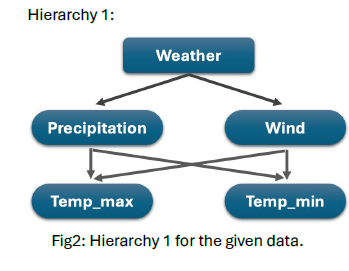
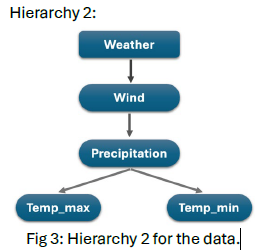

## Hierarchy 1:

In [51]:
# Define the hierarchy
modelfig2 = BayesianNetwork([
    ('weather', 'precipitation'), ('weather', 'wind'),
    ('precipitation', 'temp_max'), ('precipitation', 'temp_min'),
    ('wind', 'temp_max'), ('wind', 'temp_min')
])

# And, the states for each variables
weather_states = ['drizzle', 'rain', 'sun', 'snow', 'fog']
precipitation_states = ['low', 'mid', 'high']
wind_states = ['low', 'mid', 'high']
temp_max_states = ['low', 'mid', 'high']
temp_min_states = ['low', 'mid', 'high']


In [52]:
# Calculate Probabilities

# Weather does not have any parents so all we need are the marginal probabilities of observing each weather type
weather_marginal = (df['weather'].value_counts()/len(df['weather'])).round(3)
weather_marginal = np.array([[value] for value in weather_marginal])

# Joint Propabilities
# Create dict where key=parent, value=child
var_dict = {'weather': ['precipitation', 'wind']
            }

# Create conditional distributions and store results in a list
cpd_lst = []
for key, value in var_dict.items():
    length = len(value)
    for i in range(length):
        value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
        cpd = value_given_key.unstack(fill_value=0).to_numpy().T
        cpd_lst.append(cpd)

temp_max = df.groupby(['precipitation', 'wind'])['temp_max'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T
for i in temp_max:
    i[0] = 0.33
    i[1] = 0.33
    i[2] = 0.33
cpd_lst.append(temp_max)

temp_min = df.groupby(['precipitation', 'wind'])['temp_min'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T
for i in temp_min:
    i[0] = 0.33
    i[1] = 0.33
    i[2] = 0.33
cpd_lst.append(temp_min)

cpd_lst


C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_5416\1439350072.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_max = df.groupby(['precipitation', 'wind'])['temp_max'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T
C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_5416\1439350072.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_min = df.groupby(['precipitation', 'wind'])['temp_min'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T


[array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 1.        , 0.7800312 , 0.69230769, 1.        ],
        [0.        , 0.        , 0.2199688 , 0.30769231, 0.        ]]),
 array([[0.30188679, 0.35643564, 0.10452418, 0.07692308, 0.140625  ],
        [0.67924528, 0.58415842, 0.64118565, 0.38461538, 0.775     ],
        [0.01886792, 0.05940594, 0.25429017, 0.53846154, 0.084375  ]]),
 array([[0.33      , 0.33      , 0.33      , 0.25961538, 0.12903226,
         0.2816092 , 1.        , 0.14634146, 0.1875    ],
        [0.33      , 0.33      , 0.33      , 0.60576923, 0.60215054,
         0.66666667, 0.        , 0.82926829, 0.8125    ],
        [0.33      , 0.33      , 0.33      , 0.13461538, 0.2688172 ,
         0.05172414, 0.        , 0.02439024, 0.        ]]),
 array([[0.33      , 0.33      , 0.33      , 0.25961538, 0.14516129,
         0.20689655, 0.33333333, 0.1097561 , 0.109375  ],
        [0.33      , 0.33      , 0.33      , 0.61057692, 0.5838709

In [53]:
# Creating tabular conditional probability distribution
weather_cpd = TabularCPD(variable='weather', variable_card=5, values=weather_marginal, state_names={'weather': weather_states})

precipitation_cpd = TabularCPD(variable='precipitation', variable_card=3, evidence=['weather'], evidence_card=[5],
                               values=cpd_lst[0], state_names={'precipitation': precipitation_states, 'weather': weather_states})

wind_cpd = TabularCPD(variable='wind', variable_card=3, evidence=['weather'], evidence_card=[5],
                               values=cpd_lst[1], state_names={'wind': wind_states, 'weather': weather_states})

temp_max_cpd = TabularCPD(variable='temp_max', variable_card=3, evidence=['precipitation', 'wind'], evidence_card=[3, 3], # Cardinality of precipitation and wind
                               values=cpd_lst[2], state_names={'temp_max': temp_max_states, 'precipitation': precipitation_states, 'wind': wind_states})

temp_min_cpd = TabularCPD(variable='temp_min', variable_card=3, evidence=['precipitation', 'wind'], evidence_card=[3, 3],
                               values=cpd_lst[3], state_names={'temp_min': temp_min_states,'precipitation': precipitation_states, 'wind': wind_states})


In [54]:
# Add CPDs and factors to the model
modelfig2.add_cpds(weather_cpd, precipitation_cpd, wind_cpd, temp_max_cpd, temp_min_cpd)

# Check if model is consistent
modelfig2.check_model()

# Viewing nodes of the model
modelfig2.nodes()

# Viewing edges of the model
modelfig2.edges()

# Print the probability table of the weather node
print(weather_cpd)

# Print the probability table of the wind node
print(wind_cpd)

# Independcies in the model
modelfig2.get_independencies()
# Checking independcies of a particular node
modelfig2.local_independencies('temp_max')



+------------------+-------+
| weather(drizzle) | 0.439 |
+------------------+-------+
| weather(rain)    | 0.438 |
+------------------+-------+
| weather(sun)     | 0.069 |
+------------------+-------+
| weather(snow)    | 0.036 |
+------------------+-------+
| weather(fog)     | 0.018 |
+------------------+-------+
+------------+----------------------+-----+--------------+
| weather    | weather(drizzle)     | ... | weather(fog) |
+------------+----------------------+-----+--------------+
| wind(low)  | 0.3018867924528302   | ... | 0.140625     |
+------------+----------------------+-----+--------------+
| wind(mid)  | 0.6792452830188679   | ... | 0.775        |
+------------+----------------------+-----+--------------+
| wind(high) | 0.018867924528301886 | ... | 0.084375     |
+------------+----------------------+-----+--------------+


(temp_max ⟂ weather, temp_min | wind, precipitation)

# Hierarchy 2

In [55]:
# Define the hierarchy
modelfig3 = BayesianNetwork([
    ('weather', 'wind'), 
    ('wind', 'precipitation'),
    ('precipitation', 'temp_max'), ('precipitation', 'temp_min')
])

# And, the states for each variables
weather_states = ['drizzle', 'rain', 'sun', 'snow', 'fog']
precipitation_states = ['low', 'mid', 'high']
wind_states = ['low', 'mid', 'high']
temp_max_states = ['low', 'mid', 'high']
temp_min_states = ['low', 'mid', 'high']


In [56]:
# Calculate Probabilities

# Weather does not have any parents so all we need are the marginal probabilities of observing each weather type
weather_marginal = (df['weather'].value_counts()/len(df['weather'])).round(3)
weather_marginal = np.array([[value] for value in weather_marginal])

# Joint Propabilities
# Create dict where key=parent, value=child
var_dict = {'weather': ['wind'],
            'wind': ['precipitation'],
            'precipitation': ['temp_max', 'temp_min']
            }

# Create conditional distributions and store results in a list
cpd_lst = []
for key, value in var_dict.items():
    length = len(value)
    for i in range(length):
        value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
        cpd = value_given_key.unstack(fill_value=0).to_numpy().T
        cpd_lst.append(cpd)
# Note that we get 3 Nan values in the above conditional distributions. This is because one of the type of precipitation (low) did not contain any relation with temp_max.
# Therefore, normalization, does not produce the intended result.
# To mitigate this, we replace Nan with the equal probability within the three values, i.e., 0.33
cpd_lst[2][:,0] = .33
cpd_lst[3][:,0] = .33
cpd_lst


C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_5416\2147419593.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_5416\2147419593.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_5416\2147419593.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

[array([[0.30188679, 0.35643564, 0.10452418, 0.07692308, 0.140625  ],
        [0.67924528, 0.58415842, 0.64118565, 0.38461538, 0.775     ],
        [0.01886792, 0.05940594, 0.25429017, 0.53846154, 0.084375  ]]),
 array([[0.        , 0.        , 0.        ],
        [0.98578199, 0.91897233, 0.73109244],
        [0.01421801, 0.08102767, 0.26890756]]),
 array([[0.33      , 0.16996951, 0.18120805],
        [0.33      , 0.61128049, 0.80536913],
        [0.33      , 0.21875   , 0.01342282]]),
 array([[0.33      , 0.1714939 , 0.11409396],
        [0.33      , 0.61051829, 0.77181208],
        [0.33      , 0.2179878 , 0.11409396]])]

In [57]:
# Creating tabular conditional probability distribution
weather_cpd = TabularCPD(variable='weather', variable_card=5, values=weather_marginal, state_names={'weather': weather_states})

wind_cpd = TabularCPD(variable='wind', variable_card=3, evidence=['weather'], evidence_card=[5],
                               values=cpd_lst[0], state_names={'wind': wind_states, 'weather': weather_states})

precipitation_cpd = TabularCPD(variable='precipitation', variable_card=3, evidence=['wind'], evidence_card=[3],
                               values=cpd_lst[1], state_names={'precipitation': precipitation_states, 'wind': wind_states})

temp_max_cpd = TabularCPD(variable='temp_max', variable_card=3, evidence=['precipitation'], evidence_card=[3],
                               values=cpd_lst[2], state_names={'temp_max': temp_max_states, 'precipitation': precipitation_states})

temp_min_cpd = TabularCPD(variable='temp_min', variable_card=3, evidence=['precipitation'], evidence_card=[3],
                               values=cpd_lst[3], state_names={'temp_min': temp_min_states, 'precipitation': precipitation_states})


In [58]:
# Add CPDs and factors to the model
modelfig3.add_cpds(weather_cpd, precipitation_cpd, wind_cpd, temp_max_cpd, temp_min_cpd)

# Check if model is consistent
modelfig3.check_model()

# Viewing nodes of the model
modelfig3.nodes()

# Viewing edges of the model
modelfig3.edges()

# Print the probability table of the weather node
print(weather_cpd)

# Print the probability table of the wind node
print(wind_cpd)
# Independcies in the model
modelfig3.get_independencies()
# Checking independcies of a particular node
modelfig3.local_independencies('temp_max')


+------------------+-------+
| weather(drizzle) | 0.439 |
+------------------+-------+
| weather(rain)    | 0.438 |
+------------------+-------+
| weather(sun)     | 0.069 |
+------------------+-------+
| weather(snow)    | 0.036 |
+------------------+-------+
| weather(fog)     | 0.018 |
+------------------+-------+
+------------+----------------------+-----+--------------+
| weather    | weather(drizzle)     | ... | weather(fog) |
+------------+----------------------+-----+--------------+
| wind(low)  | 0.3018867924528302   | ... | 0.140625     |
+------------+----------------------+-----+--------------+
| wind(mid)  | 0.6792452830188679   | ... | 0.775        |
+------------+----------------------+-----+--------------+
| wind(high) | 0.018867924528301886 | ... | 0.084375     |
+------------+----------------------+-----+--------------+


(temp_max ⟂ wind, weather, temp_min | precipitation)

1.4.2 Compare the joint probabilities from all the three-hierarchy using either exact or approximate inference? Discuss your results?

In [59]:
inference1 = VariableElimination(modelfig1)
joint_prob1 = inference1.query(variables=['weather', 'precipitation', 'wind', 'temp_max', 'temp_min'], joint=True)

inference2 = VariableElimination(modelfig2)
joint_prob2 = inference2.query(variables=['weather', 'precipitation', 'wind', 'temp_max', 'temp_min'], joint=True)

inference3 = VariableElimination(modelfig3)
joint_prob3 = inference3.query(variables=['weather', 'precipitation', 'wind', 'temp_max', 'temp_min'], joint=True)

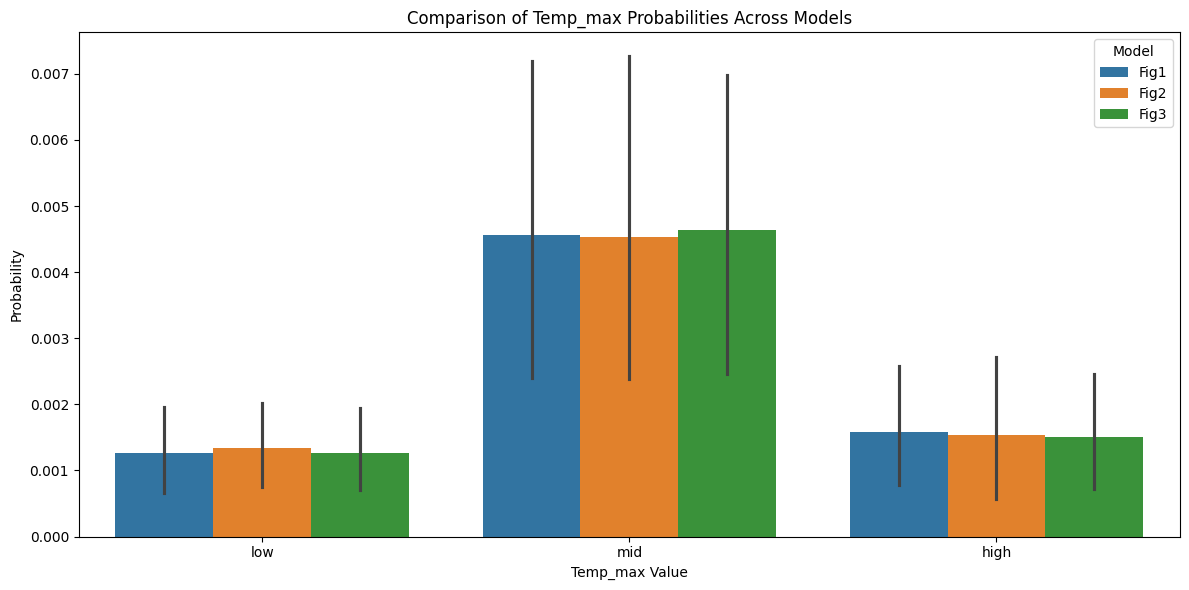

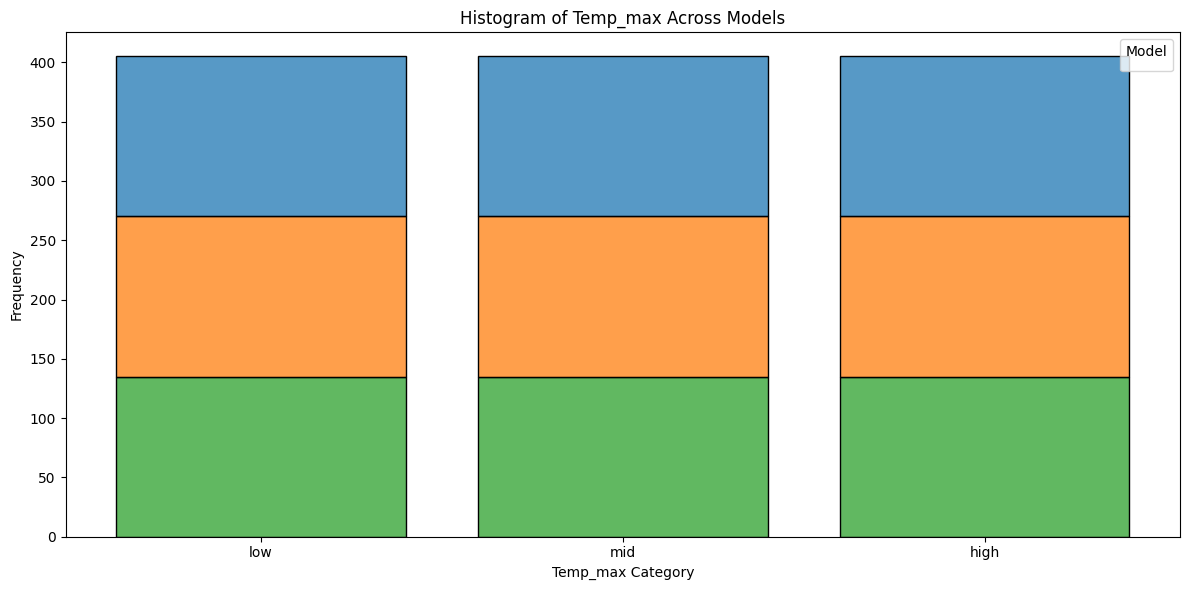

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def factor_to_df(factor, model_label):
    """ Converts a DiscreteFactor object to a pandas DataFrame.
        Flattens multi-dimensional joint probability arrays and labels each entry.
    """
    # Flatten the factor values and create a product of state names for indexing
    flat_values = factor.values.flatten()
    index = pd.MultiIndex.from_product(factor.state_names.values(), names=factor.variables)
    df = pd.DataFrame(flat_values, index=index, columns=['probability'])
    df = df.reset_index()
    df['Model'] = model_label  # Assigning model label
    return df

# Assume joint_prob1, joint_prob2, joint_prob3 are defined DiscreteFactor objects
df1 = factor_to_df(joint_prob1, 'Fig1')
df2 = factor_to_df(joint_prob2, 'Fig2')
df3 = factor_to_df(joint_prob3, 'Fig3')

# Concatenate all DataFrames into one DataFrame for visualization
all_samples = pd.concat([df1, df2, df3])

# Bar plot of Temp_max frequencies across models
plt.figure(figsize=(12, 6))
sns.barplot(x='temp_max', y='probability', hue='Model', data=all_samples)
plt.title('Comparison of Temp_max Probabilities Across Models')
plt.xlabel('Temp_max Value')
plt.ylabel('Probability')
plt.legend(title='Model')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

# Density Plot of Temp_max across models
plt.figure(figsize=(12, 6))
sns.histplot(data=all_samples, x='temp_max', hue='Model', multiple="stack", shrink=0.8)
plt.title('Histogram of Temp_max Across Models')
plt.xlabel('Temp_max Category')
plt.ylabel('Frequency')
plt.legend(title='Model')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()




In [61]:
sampler1 = BayesianModelSampling(modelfig1)
samples1 = sampler1.forward_sample(size=10000)

sampler2 = BayesianModelSampling(modelfig2)
samples2 = sampler2.forward_sample(size=10000)

sampler3 = BayesianModelSampling(modelfig3)
samples3 = sampler3.forward_sample(size=10000)

Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 181.45it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 110.92it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
Generating for node: temp_min: 100%|██████████| 5/5 [00:00<00:00, 95.20it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_in

In [62]:
import pandas as pd

# Convert the samples to pandas DataFrames for easier manipulation
df1 = pd.DataFrame(samples1)
df2 = pd.DataFrame(samples2)
df3 = pd.DataFrame(samples3)

# Add a model label for easier plotting and analysis
df1['Model'] = 'Fig1'
df2['Model'] = 'Fig2'
df3['Model'] = 'Fig3'

# Concatenate all samples into one DataFrame
all_samples = pd.concat([df1, df2, df3])


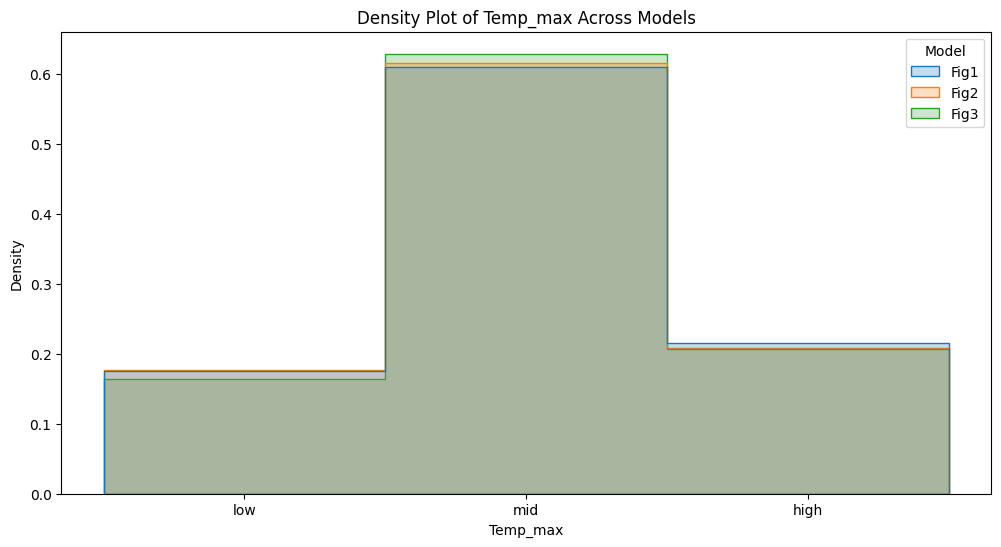

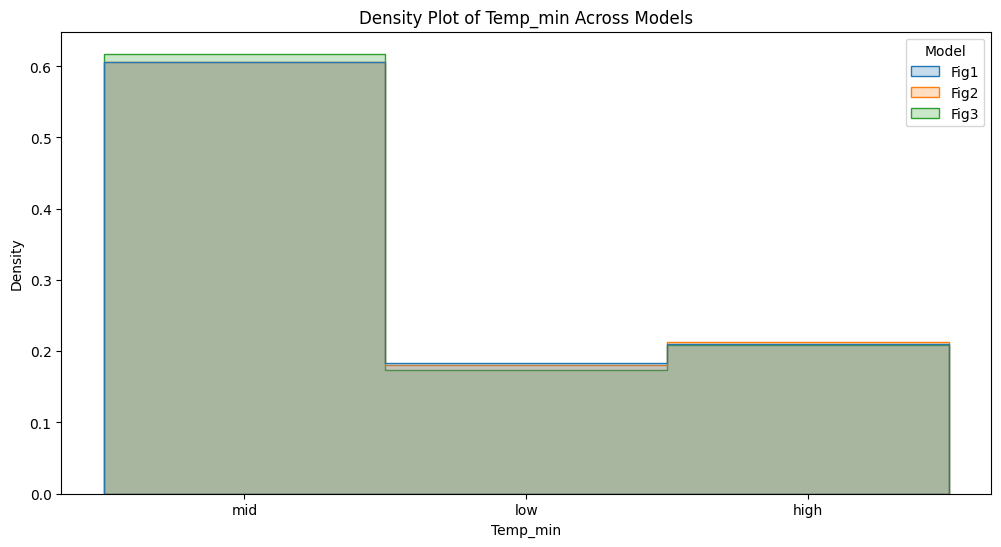

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of Temp_max across different models
plt.figure(figsize=(12, 6))
sns.histplot(data=all_samples, x='temp_max', hue='Model', element='step', stat='density', common_norm=False)
plt.title('Density Plot of Temp_max Across Models')
plt.xlabel('Temp_max')
plt.ylabel('Density')
plt.show()

# Visualize the distribution of Temp_min similarly
plt.figure(figsize=(12, 6))
sns.histplot(data=all_samples, x='temp_min', hue='Model', element='step', stat='density', common_norm=False)
plt.title('Density Plot of Temp_min Across Models')
plt.xlabel('Temp_min')
plt.ylabel('Density')
plt.show()
